In [39]:
import numpy as np
import cv2
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

directory = 'img_align_celeba/img_align_celeba/'
how_many = 100
celeba_img = np.sort(os.listdir(directory))
dataset = celeba_img[:how_many]
img_shape = (178, 218, 3)

def load_dataset(dataset):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    return(X)

In [43]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (4,4), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 20x20
    model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 10x10
    model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 128)))
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 80x80x3
    model.add(Conv2D(3, (4,4), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate ✬real✬ class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create ✬fake✬ class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# create and save a p
def save_plot(examples, epoch, n=4):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    # save plot to file
    filename = 'model_img/generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'models/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=32):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            # evaluate the model performance, sometimes
        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [44]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_real_samples()
dataset = load_dataset(dataset)

In [45]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/781, d1=0.702, d2=0.695 g=0.692
>1, 2/781, d1=0.609, d2=0.695 g=0.692
>1, 3/781, d1=0.461, d2=0.699 g=0.689
>1, 4/781, d1=0.232, d2=0.715 g=0.677
>1, 5/781, d1=0.044, d2=0.749 g=0.667
>1, 6/781, d1=0.018, d2=0.767 g=0.672
>1, 7/781, d1=0.015, d2=0.731 g=0.699
>1, 8/781, d1=0.019, d2=0.681 g=0.738
>1, 9/781, d1=0.011, d2=0.641 g=0.823
>1, 10/781, d1=0.024, d2=0.603 g=0.913
>1, 11/781, d1=0.001, d2=0.553 g=1.025
>1, 12/781, d1=0.005, d2=0.488 g=1.151
>1, 13/781, d1=0.010, d2=0.426 g=1.355
>1, 14/781, d1=0.002, d2=0.316 g=1.721
>1, 15/781, d1=0.049, d2=0.225 g=1.969
>1, 16/781, d1=0.000, d2=0.141 g=2.570
>1, 17/781, d1=0.000, d2=0.098 g=3.291
>1, 18/781, d1=0.000, d2=0.211 g=4.534
>1, 19/781, d1=0.000, d2=0.016 g=7.007
>1, 20/781, d1=0.000, d2=0.016 g=11.022
>1, 21/781, d1=0.000, d2=0.000 g=10.971
>1, 22/781, d1=0.000, d2=0.002 g=7.952
>1, 23/781, d1=0.000, d2=0.885 g=21.990
>1, 24/781, d1=0.000, d2=0.000 g=25.847
>1, 25/781, d1=1.452, d2=0.000 g=10.477
>1, 26/781, d1=0.017, d2=0.00

>1, 208/781, d1=0.107, d2=0.593 g=0.875
>1, 209/781, d1=0.084, d2=0.560 g=0.966
>1, 210/781, d1=0.012, d2=0.515 g=1.089
>1, 211/781, d1=0.348, d2=0.758 g=0.606
>1, 212/781, d1=0.001, d2=0.900 g=0.677
>1, 213/781, d1=0.003, d2=0.754 g=0.837
>1, 214/781, d1=0.004, d2=0.566 g=0.914
>1, 215/781, d1=0.072, d2=0.529 g=0.959
>1, 216/781, d1=0.066, d2=0.472 g=1.010
>1, 217/781, d1=0.022, d2=0.476 g=1.050
>1, 218/781, d1=0.021, d2=0.437 g=1.168
>1, 219/781, d1=0.014, d2=0.404 g=1.223
>1, 220/781, d1=0.042, d2=0.337 g=1.323
>1, 221/781, d1=0.017, d2=0.323 g=1.406
>1, 222/781, d1=0.031, d2=0.264 g=1.500
>1, 223/781, d1=0.011, d2=0.248 g=1.620
>1, 224/781, d1=0.021, d2=0.238 g=1.654
>1, 225/781, d1=0.014, d2=0.201 g=1.793
>1, 226/781, d1=0.041, d2=0.213 g=1.813
>1, 227/781, d1=0.081, d2=0.234 g=1.720
>1, 228/781, d1=0.021, d2=0.251 g=1.947
>1, 229/781, d1=0.008, d2=0.169 g=2.505
>1, 230/781, d1=0.015, d2=0.070 g=2.966
>1, 231/781, d1=0.510, d2=0.177 g=1.873
>1, 232/781, d1=0.005, d2=0.255 g=2.153


>1, 413/781, d1=1.718, d2=0.024 g=4.075
>1, 414/781, d1=0.653, d2=0.079 g=2.417
>1, 415/781, d1=0.121, d2=0.232 g=2.174
>1, 416/781, d1=0.173, d2=0.277 g=2.549
>1, 417/781, d1=0.322, d2=0.255 g=2.370
>1, 418/781, d1=0.172, d2=0.390 g=2.815
>1, 419/781, d1=0.262, d2=0.163 g=2.826
>1, 420/781, d1=0.197, d2=0.308 g=3.232
>1, 421/781, d1=0.272, d2=0.082 g=3.142
>1, 422/781, d1=0.358, d2=0.531 g=4.123
>1, 423/781, d1=0.751, d2=0.050 g=3.031
>1, 424/781, d1=0.151, d2=0.141 g=3.100
>1, 425/781, d1=0.128, d2=0.188 g=3.818
>1, 426/781, d1=0.148, d2=0.042 g=3.606
>1, 427/781, d1=0.158, d2=0.118 g=3.073
>1, 428/781, d1=0.282, d2=0.219 g=3.578
>1, 429/781, d1=0.266, d2=0.107 g=3.218
>1, 430/781, d1=0.148, d2=0.168 g=3.128
>1, 431/781, d1=0.009, d2=0.159 g=3.570
>1, 432/781, d1=0.403, d2=0.279 g=3.395
>1, 433/781, d1=0.136, d2=0.264 g=3.189
>1, 434/781, d1=0.603, d2=0.506 g=4.175
>1, 435/781, d1=1.167, d2=0.263 g=2.598
>1, 436/781, d1=0.982, d2=0.783 g=2.797
>1, 437/781, d1=0.751, d2=0.218 g=2.680


>1, 618/781, d1=0.438, d2=0.257 g=2.652
>1, 619/781, d1=0.119, d2=0.155 g=2.422
>1, 620/781, d1=0.460, d2=0.380 g=2.310
>1, 621/781, d1=0.248, d2=0.244 g=2.097
>1, 622/781, d1=0.197, d2=0.296 g=2.855
>1, 623/781, d1=0.315, d2=0.111 g=2.625
>1, 624/781, d1=0.031, d2=0.143 g=2.856
>1, 625/781, d1=0.542, d2=0.139 g=2.274
>1, 626/781, d1=0.315, d2=0.424 g=2.473
>1, 627/781, d1=0.242, d2=0.110 g=3.626
>1, 628/781, d1=0.411, d2=0.124 g=2.827
>1, 629/781, d1=0.302, d2=0.193 g=2.626
>1, 630/781, d1=0.123, d2=0.127 g=2.804
>1, 631/781, d1=0.028, d2=0.103 g=2.969
>1, 632/781, d1=0.194, d2=0.106 g=2.863
>1, 633/781, d1=0.147, d2=0.368 g=3.559
>1, 634/781, d1=0.142, d2=0.082 g=3.364
>1, 635/781, d1=0.329, d2=0.305 g=2.792
>1, 636/781, d1=0.681, d2=0.330 g=2.414
>1, 637/781, d1=0.214, d2=0.366 g=3.069
>1, 638/781, d1=0.100, d2=0.066 g=3.202
>1, 639/781, d1=0.305, d2=0.412 g=3.323
>1, 640/781, d1=0.487, d2=0.240 g=2.610
>1, 641/781, d1=0.171, d2=0.238 g=2.840
>1, 642/781, d1=0.517, d2=0.283 g=2.842


>2, 43/781, d1=0.181, d2=0.109 g=2.693
>2, 44/781, d1=0.076, d2=0.408 g=3.111
>2, 45/781, d1=0.178, d2=0.109 g=3.206
>2, 46/781, d1=0.399, d2=0.283 g=2.944
>2, 47/781, d1=0.314, d2=0.143 g=3.129
>2, 48/781, d1=0.256, d2=0.136 g=2.902
>2, 49/781, d1=0.099, d2=0.270 g=3.651
>2, 50/781, d1=0.402, d2=0.273 g=3.083
>2, 51/781, d1=0.090, d2=0.150 g=3.115
>2, 52/781, d1=0.450, d2=0.532 g=2.956
>2, 53/781, d1=0.448, d2=0.313 g=2.939
>2, 54/781, d1=0.504, d2=0.478 g=2.989
>2, 55/781, d1=0.502, d2=0.748 g=3.198
>2, 56/781, d1=0.842, d2=0.121 g=2.672
>2, 57/781, d1=0.533, d2=0.226 g=1.911
>2, 58/781, d1=0.280, d2=0.342 g=2.001
>2, 59/781, d1=0.212, d2=0.234 g=2.274
>2, 60/781, d1=0.522, d2=0.317 g=2.226
>2, 61/781, d1=0.153, d2=0.243 g=2.438
>2, 62/781, d1=0.231, d2=0.152 g=2.693
>2, 63/781, d1=0.229, d2=0.190 g=2.715
>2, 64/781, d1=0.234, d2=0.431 g=3.531
>2, 65/781, d1=0.655, d2=0.108 g=2.478
>2, 66/781, d1=0.258, d2=0.426 g=2.869
>2, 67/781, d1=0.289, d2=0.121 g=2.937
>2, 68/781, d1=0.236, d2=

>2, 250/781, d1=0.713, d2=0.275 g=3.068
>2, 251/781, d1=0.121, d2=0.373 g=4.491
>2, 252/781, d1=0.388, d2=0.067 g=3.521
>2, 253/781, d1=0.150, d2=0.301 g=3.464
>2, 254/781, d1=0.147, d2=0.246 g=4.319
>2, 255/781, d1=0.343, d2=0.111 g=3.244
>2, 256/781, d1=0.246, d2=0.496 g=3.959
>2, 257/781, d1=0.205, d2=0.086 g=3.597
>2, 258/781, d1=0.617, d2=0.287 g=2.705
>2, 259/781, d1=0.430, d2=0.670 g=3.265
>2, 260/781, d1=0.325, d2=0.098 g=3.069
>2, 261/781, d1=0.455, d2=0.270 g=2.461
>2, 262/781, d1=0.233, d2=0.371 g=3.171
>2, 263/781, d1=0.348, d2=0.135 g=2.435
>2, 264/781, d1=0.172, d2=0.366 g=2.719
>2, 265/781, d1=0.423, d2=0.385 g=3.725
>2, 266/781, d1=0.251, d2=0.150 g=3.594
>2, 267/781, d1=0.724, d2=0.375 g=2.563
>2, 268/781, d1=0.186, d2=0.216 g=3.368
>2, 269/781, d1=0.110, d2=0.118 g=3.462
>2, 270/781, d1=0.278, d2=0.116 g=3.483
>2, 271/781, d1=0.243, d2=0.364 g=3.214
>2, 272/781, d1=0.346, d2=0.466 g=3.972
>2, 273/781, d1=0.324, d2=0.213 g=4.054
>2, 274/781, d1=0.158, d2=0.169 g=3.968


>2, 455/781, d1=0.104, d2=0.063 g=4.063
>2, 456/781, d1=0.446, d2=0.207 g=3.525
>2, 457/781, d1=0.335, d2=0.336 g=3.378
>2, 458/781, d1=0.054, d2=0.063 g=4.005
>2, 459/781, d1=0.566, d2=0.540 g=3.229
>2, 460/781, d1=0.401, d2=0.242 g=3.487
>2, 461/781, d1=0.253, d2=0.228 g=3.850
>2, 462/781, d1=0.234, d2=0.167 g=4.491
>2, 463/781, d1=0.141, d2=0.098 g=3.985
>2, 464/781, d1=0.468, d2=0.730 g=5.438
>2, 465/781, d1=0.271, d2=0.008 g=5.564
>2, 466/781, d1=0.483, d2=0.116 g=3.101
>2, 467/781, d1=0.031, d2=0.605 g=5.156
>2, 468/781, d1=0.443, d2=0.019 g=3.619
>2, 469/781, d1=0.258, d2=0.674 g=5.013
>2, 470/781, d1=0.197, d2=0.127 g=4.777
>2, 471/781, d1=0.696, d2=0.165 g=2.343
>2, 472/781, d1=0.094, d2=0.244 g=2.751
>2, 473/781, d1=0.175, d2=0.199 g=3.116
>2, 474/781, d1=0.302, d2=0.172 g=2.849
>2, 475/781, d1=0.095, d2=0.169 g=3.319
>2, 476/781, d1=0.571, d2=0.296 g=2.798
>2, 477/781, d1=0.138, d2=0.172 g=3.764
>2, 478/781, d1=0.341, d2=0.108 g=3.335
>2, 479/781, d1=0.166, d2=0.241 g=3.492


>2, 660/781, d1=0.229, d2=0.244 g=2.943
>2, 661/781, d1=0.168, d2=0.251 g=3.778
>2, 662/781, d1=0.254, d2=0.188 g=3.908
>2, 663/781, d1=0.305, d2=0.226 g=3.774
>2, 664/781, d1=0.726, d2=0.283 g=3.092
>2, 665/781, d1=0.182, d2=0.244 g=3.631
>2, 666/781, d1=0.109, d2=0.162 g=4.501
>2, 667/781, d1=0.048, d2=0.032 g=4.008
>2, 668/781, d1=0.135, d2=0.123 g=3.687
>2, 669/781, d1=0.141, d2=0.142 g=3.450
>2, 670/781, d1=0.100, d2=0.113 g=3.611
>2, 671/781, d1=0.411, d2=0.100 g=2.898
>2, 672/781, d1=0.052, d2=0.192 g=4.378
>2, 673/781, d1=0.021, d2=0.033 g=4.605
>2, 674/781, d1=0.534, d2=0.146 g=2.797
>2, 675/781, d1=0.038, d2=0.197 g=4.009
>2, 676/781, d1=0.079, d2=0.057 g=4.453
>2, 677/781, d1=0.119, d2=0.104 g=4.127
>2, 678/781, d1=0.081, d2=0.071 g=4.148
>2, 679/781, d1=0.174, d2=0.223 g=3.871
>2, 680/781, d1=0.368, d2=0.077 g=3.907
>2, 681/781, d1=0.042, d2=0.194 g=4.769
>2, 682/781, d1=0.222, d2=0.072 g=5.032
>2, 683/781, d1=0.339, d2=0.140 g=4.195
>2, 684/781, d1=0.510, d2=0.384 g=4.065


>3, 86/781, d1=0.136, d2=0.444 g=4.389
>3, 87/781, d1=0.035, d2=0.025 g=4.581
>3, 88/781, d1=0.187, d2=0.227 g=4.376
>3, 89/781, d1=0.429, d2=0.131 g=2.914
>3, 90/781, d1=0.050, d2=0.343 g=5.528
>3, 91/781, d1=0.098, d2=0.011 g=5.357
>3, 92/781, d1=0.785, d2=0.379 g=4.540
>3, 93/781, d1=0.276, d2=0.071 g=4.975
>3, 94/781, d1=0.018, d2=0.035 g=4.520
>3, 95/781, d1=0.049, d2=0.310 g=5.278
>3, 96/781, d1=0.085, d2=0.092 g=4.590
>3, 97/781, d1=0.533, d2=0.322 g=4.364
>3, 98/781, d1=0.777, d2=0.428 g=5.875
>3, 99/781, d1=0.504, d2=0.021 g=5.398
>3, 100/781, d1=0.192, d2=0.197 g=4.155
>3, 101/781, d1=0.067, d2=0.103 g=4.095
>3, 102/781, d1=0.205, d2=0.174 g=3.962
>3, 103/781, d1=0.294, d2=0.342 g=5.339
>3, 104/781, d1=0.462, d2=0.175 g=5.434
>3, 105/781, d1=0.102, d2=0.096 g=4.496
>3, 106/781, d1=0.459, d2=0.908 g=8.360
>3, 107/781, d1=0.883, d2=0.001 g=7.950
>3, 108/781, d1=0.357, d2=0.025 g=4.792
>3, 109/781, d1=0.058, d2=0.144 g=3.779
>3, 110/781, d1=0.039, d2=0.500 g=5.938
>3, 111/781, d

>3, 292/781, d1=0.103, d2=0.544 g=5.193
>3, 293/781, d1=0.149, d2=0.011 g=5.898
>3, 294/781, d1=0.284, d2=0.043 g=3.714
>3, 295/781, d1=0.112, d2=0.298 g=4.564
>3, 296/781, d1=0.206, d2=0.092 g=4.209
>3, 297/781, d1=0.165, d2=0.064 g=3.841
>3, 298/781, d1=0.096, d2=0.268 g=4.986
>3, 299/781, d1=0.210, d2=0.069 g=4.124
>3, 300/781, d1=0.117, d2=0.144 g=4.184
>3, 301/781, d1=0.254, d2=0.097 g=4.311
>3, 302/781, d1=0.035, d2=0.224 g=4.317
>3, 303/781, d1=0.245, d2=0.045 g=3.665
>3, 304/781, d1=0.016, d2=0.473 g=5.972
>3, 305/781, d1=0.693, d2=0.020 g=4.142
>3, 306/781, d1=0.557, d2=0.566 g=4.938
>3, 307/781, d1=0.017, d2=0.026 g=5.584
>3, 308/781, d1=0.053, d2=0.028 g=4.384
>3, 309/781, d1=0.322, d2=0.229 g=4.498
>3, 310/781, d1=0.191, d2=0.149 g=4.364
>3, 311/781, d1=0.217, d2=0.171 g=4.425
>3, 312/781, d1=0.223, d2=0.031 g=3.917
>3, 313/781, d1=0.373, d2=0.347 g=5.073
>3, 314/781, d1=0.374, d2=0.027 g=4.090
>3, 315/781, d1=0.110, d2=0.574 g=5.181
>3, 316/781, d1=0.441, d2=0.037 g=3.374


>3, 497/781, d1=0.031, d2=0.135 g=4.591
>3, 498/781, d1=0.101, d2=0.141 g=5.254
>3, 499/781, d1=0.443, d2=0.035 g=4.109
>3, 500/781, d1=0.012, d2=0.240 g=5.567
>3, 501/781, d1=0.450, d2=0.090 g=4.299
>3, 502/781, d1=0.041, d2=0.125 g=4.615
>3, 503/781, d1=0.543, d2=0.376 g=4.852
>3, 504/781, d1=0.345, d2=0.190 g=3.778
>3, 505/781, d1=0.363, d2=0.287 g=5.167
>3, 506/781, d1=0.178, d2=0.062 g=4.956
>3, 507/781, d1=0.176, d2=0.115 g=4.812
>3, 508/781, d1=0.183, d2=0.086 g=3.592
>3, 509/781, d1=0.009, d2=0.456 g=6.000
>3, 510/781, d1=0.860, d2=0.565 g=6.818
>3, 511/781, d1=0.362, d2=0.010 g=6.045
>3, 512/781, d1=0.178, d2=0.032 g=3.998
>3, 513/781, d1=0.110, d2=0.243 g=4.081
>3, 514/781, d1=0.047, d2=0.082 g=4.281
>3, 515/781, d1=0.051, d2=0.098 g=3.752
>3, 516/781, d1=0.161, d2=0.116 g=3.449
>3, 517/781, d1=0.360, d2=0.289 g=4.015
>3, 518/781, d1=0.236, d2=0.079 g=3.705
>3, 519/781, d1=0.171, d2=0.165 g=4.213
>3, 520/781, d1=0.196, d2=0.061 g=3.228
>3, 521/781, d1=0.333, d2=0.297 g=4.197


>3, 702/781, d1=0.041, d2=0.069 g=4.652
>3, 703/781, d1=0.450, d2=0.237 g=3.081
>3, 704/781, d1=0.121, d2=0.148 g=3.974
>3, 705/781, d1=0.156, d2=0.118 g=3.867
>3, 706/781, d1=0.070, d2=0.328 g=4.598
>3, 707/781, d1=0.128, d2=0.020 g=5.075
>3, 708/781, d1=0.413, d2=0.194 g=3.378
>3, 709/781, d1=0.223, d2=0.296 g=4.707
>3, 710/781, d1=0.365, d2=0.054 g=3.438
>3, 711/781, d1=0.074, d2=0.234 g=5.082
>3, 712/781, d1=0.606, d2=0.075 g=3.168
>3, 713/781, d1=0.151, d2=0.388 g=4.781
>3, 714/781, d1=0.144, d2=0.022 g=5.131
>3, 715/781, d1=0.286, d2=0.104 g=3.555
>3, 716/781, d1=0.037, d2=0.202 g=4.131
>3, 717/781, d1=0.459, d2=0.347 g=3.867
>3, 718/781, d1=0.096, d2=0.203 g=4.209
>3, 719/781, d1=0.381, d2=0.230 g=5.215
>3, 720/781, d1=0.129, d2=0.039 g=4.178
>3, 721/781, d1=0.461, d2=0.139 g=2.945
>3, 722/781, d1=0.068, d2=0.289 g=4.643
>3, 723/781, d1=0.137, d2=0.037 g=4.564
>3, 724/781, d1=0.443, d2=0.143 g=3.828
>3, 725/781, d1=0.029, d2=0.065 g=4.510
>3, 726/781, d1=0.054, d2=0.046 g=3.719


>4, 128/781, d1=0.077, d2=0.057 g=4.150
>4, 129/781, d1=0.385, d2=0.289 g=3.698
>4, 130/781, d1=0.452, d2=0.172 g=3.817
>4, 131/781, d1=0.187, d2=0.162 g=4.043
>4, 132/781, d1=0.528, d2=0.346 g=3.862
>4, 133/781, d1=0.115, d2=0.087 g=3.384
>4, 134/781, d1=0.235, d2=0.273 g=3.936
>4, 135/781, d1=0.067, d2=0.125 g=4.903
>4, 136/781, d1=0.149, d2=0.068 g=4.459
>4, 137/781, d1=0.300, d2=0.379 g=5.144
>4, 138/781, d1=0.712, d2=0.038 g=3.745
>4, 139/781, d1=0.066, d2=0.289 g=5.016
>4, 140/781, d1=0.106, d2=0.028 g=6.170
>4, 141/781, d1=0.126, d2=0.029 g=4.060
>4, 142/781, d1=0.291, d2=0.145 g=2.987
>4, 143/781, d1=0.018, d2=0.196 g=4.697
>4, 144/781, d1=0.067, d2=0.033 g=4.136
>4, 145/781, d1=0.307, d2=0.185 g=3.504
>4, 146/781, d1=0.152, d2=0.194 g=3.985
>4, 147/781, d1=0.430, d2=0.214 g=3.678
>4, 148/781, d1=0.272, d2=0.238 g=3.459
>4, 149/781, d1=0.100, d2=0.115 g=3.454
>4, 150/781, d1=0.052, d2=0.136 g=3.269
>4, 151/781, d1=0.268, d2=0.492 g=4.993
>4, 152/781, d1=0.549, d2=0.058 g=4.339


>4, 333/781, d1=0.409, d2=0.258 g=3.364
>4, 334/781, d1=0.065, d2=0.136 g=4.047
>4, 335/781, d1=0.116, d2=0.066 g=3.932
>4, 336/781, d1=0.240, d2=0.145 g=3.312
>4, 337/781, d1=0.139, d2=0.117 g=3.339
>4, 338/781, d1=0.443, d2=0.365 g=4.086
>4, 339/781, d1=0.069, d2=0.031 g=4.913
>4, 340/781, d1=0.022, d2=0.035 g=3.971
>4, 341/781, d1=0.208, d2=0.266 g=4.143
>4, 342/781, d1=0.095, d2=0.125 g=4.492
>4, 343/781, d1=0.359, d2=0.096 g=4.044
>4, 344/781, d1=0.218, d2=0.195 g=4.045
>4, 345/781, d1=0.109, d2=0.550 g=6.000
>4, 346/781, d1=0.072, d2=0.016 g=6.558
>4, 347/781, d1=0.372, d2=0.661 g=6.440
>4, 348/781, d1=0.334, d2=0.016 g=5.120
>4, 349/781, d1=0.139, d2=0.038 g=3.535
>4, 350/781, d1=0.144, d2=0.428 g=5.847
>4, 351/781, d1=0.340, d2=0.025 g=4.752
>4, 352/781, d1=0.047, d2=0.039 g=3.638
>4, 353/781, d1=0.011, d2=0.302 g=5.307
>4, 354/781, d1=0.156, d2=0.062 g=4.470
>4, 355/781, d1=0.184, d2=0.202 g=3.903
>4, 356/781, d1=0.309, d2=0.300 g=5.619
>4, 357/781, d1=0.185, d2=0.099 g=5.508


>4, 538/781, d1=0.484, d2=0.086 g=4.245
>4, 539/781, d1=0.728, d2=0.451 g=3.670
>4, 540/781, d1=0.435, d2=0.223 g=3.871
>4, 541/781, d1=0.155, d2=0.176 g=3.497
>4, 542/781, d1=0.194, d2=0.087 g=3.447
>4, 543/781, d1=0.398, d2=0.449 g=3.939
>4, 544/781, d1=0.277, d2=0.095 g=4.643
>4, 545/781, d1=0.145, d2=0.085 g=4.126
>4, 546/781, d1=0.232, d2=0.196 g=3.494
>4, 547/781, d1=0.047, d2=0.079 g=3.300
>4, 548/781, d1=0.058, d2=0.655 g=5.313
>4, 549/781, d1=0.503, d2=0.039 g=4.442
>4, 550/781, d1=0.256, d2=0.179 g=3.402
>4, 551/781, d1=0.588, d2=0.613 g=2.894
>4, 552/781, d1=0.121, d2=0.217 g=3.581
>4, 553/781, d1=0.276, d2=0.115 g=3.174
>4, 554/781, d1=0.095, d2=0.198 g=3.306
>4, 555/781, d1=0.159, d2=0.214 g=3.749
>4, 556/781, d1=0.238, d2=0.186 g=3.189
>4, 557/781, d1=0.371, d2=0.209 g=3.308
>4, 558/781, d1=0.212, d2=0.253 g=3.634
>4, 559/781, d1=0.292, d2=0.112 g=3.558
>4, 560/781, d1=0.352, d2=0.339 g=3.331
>4, 561/781, d1=0.174, d2=0.086 g=3.492
>4, 562/781, d1=0.135, d2=0.211 g=3.503


>4, 743/781, d1=0.189, d2=0.006 g=5.548
>4, 744/781, d1=0.457, d2=0.114 g=4.203
>4, 745/781, d1=0.173, d2=0.210 g=3.800
>4, 746/781, d1=0.170, d2=0.122 g=3.965
>4, 747/781, d1=0.217, d2=0.368 g=4.830
>4, 748/781, d1=0.270, d2=0.048 g=4.872
>4, 749/781, d1=0.307, d2=0.159 g=4.310
>4, 750/781, d1=0.091, d2=0.291 g=5.542
>4, 751/781, d1=0.306, d2=0.038 g=4.562
>4, 752/781, d1=0.091, d2=0.597 g=5.639
>4, 753/781, d1=0.197, d2=0.008 g=5.772
>4, 754/781, d1=0.526, d2=0.071 g=3.132
>4, 755/781, d1=0.068, d2=0.344 g=4.227
>4, 756/781, d1=0.094, d2=0.065 g=4.152
>4, 757/781, d1=0.327, d2=0.092 g=2.953
>4, 758/781, d1=0.056, d2=0.212 g=3.767
>4, 759/781, d1=0.099, d2=0.240 g=4.289
>4, 760/781, d1=0.085, d2=0.060 g=4.375
>4, 761/781, d1=0.075, d2=0.100 g=3.994
>4, 762/781, d1=0.241, d2=0.175 g=3.022
>4, 763/781, d1=0.103, d2=0.426 g=5.239
>4, 764/781, d1=0.400, d2=0.029 g=4.651
>4, 765/781, d1=0.312, d2=0.228 g=4.014
>4, 766/781, d1=0.075, d2=0.073 g=3.823
>4, 767/781, d1=0.086, d2=0.307 g=4.894


>5, 169/781, d1=0.171, d2=0.073 g=3.450
>5, 170/781, d1=0.263, d2=0.242 g=3.321
>5, 171/781, d1=0.269, d2=0.229 g=3.553
>5, 172/781, d1=0.152, d2=0.166 g=3.340
>5, 173/781, d1=0.154, d2=0.220 g=3.354
>5, 174/781, d1=0.131, d2=0.129 g=3.339
>5, 175/781, d1=0.217, d2=0.267 g=3.739
>5, 176/781, d1=0.373, d2=0.217 g=4.196
>5, 177/781, d1=0.180, d2=0.126 g=4.119
>5, 178/781, d1=0.191, d2=0.103 g=2.823
>5, 179/781, d1=0.187, d2=0.589 g=5.033
>5, 180/781, d1=0.310, d2=0.019 g=4.937
>5, 181/781, d1=0.123, d2=0.037 g=3.499
>5, 182/781, d1=0.326, d2=0.779 g=5.016
>5, 183/781, d1=0.399, d2=0.023 g=5.594
>5, 184/781, d1=0.692, d2=0.243 g=3.974
>5, 185/781, d1=0.259, d2=0.145 g=3.459
>5, 186/781, d1=0.195, d2=0.228 g=3.512
>5, 187/781, d1=0.184, d2=0.258 g=3.880
>5, 188/781, d1=0.052, d2=0.089 g=4.323
>5, 189/781, d1=0.422, d2=0.110 g=2.815
>5, 190/781, d1=0.280, d2=0.771 g=5.409
>5, 191/781, d1=0.422, d2=0.014 g=5.537
>5, 192/781, d1=0.343, d2=0.069 g=2.731
>5, 193/781, d1=0.416, d2=0.879 g=3.592


>5, 374/781, d1=0.378, d2=0.296 g=2.735
>5, 375/781, d1=0.345, d2=0.401 g=3.298
>5, 376/781, d1=0.523, d2=0.203 g=2.501
>5, 377/781, d1=0.195, d2=0.245 g=2.548
>5, 378/781, d1=0.277, d2=0.416 g=3.672
>5, 379/781, d1=0.794, d2=0.163 g=3.067
>5, 380/781, d1=0.424, d2=0.410 g=3.324
>5, 381/781, d1=0.309, d2=0.141 g=3.062
>5, 382/781, d1=0.092, d2=0.091 g=3.079
>5, 383/781, d1=0.706, d2=0.567 g=2.965
>5, 384/781, d1=0.110, d2=0.234 g=3.611
>5, 385/781, d1=0.226, d2=0.090 g=3.352
>5, 386/781, d1=0.203, d2=0.118 g=2.463
>5, 387/781, d1=0.161, d2=0.321 g=2.555
>5, 388/781, d1=0.226, d2=0.276 g=3.482
>5, 389/781, d1=0.683, d2=0.408 g=3.154
>5, 390/781, d1=0.227, d2=0.178 g=2.711
>5, 391/781, d1=0.341, d2=0.325 g=2.681
>5, 392/781, d1=0.111, d2=0.186 g=3.558
>5, 393/781, d1=0.231, d2=0.136 g=3.276
>5, 394/781, d1=0.237, d2=0.222 g=3.019
>5, 395/781, d1=0.028, d2=0.173 g=3.328
>5, 396/781, d1=0.382, d2=0.312 g=3.397
>5, 397/781, d1=0.215, d2=0.280 g=3.814
>5, 398/781, d1=0.093, d2=0.080 g=3.775


>5, 579/781, d1=0.361, d2=0.301 g=2.365
>5, 580/781, d1=0.143, d2=0.297 g=3.073
>5, 581/781, d1=0.078, d2=0.122 g=3.238
>5, 582/781, d1=0.253, d2=0.148 g=3.528
>5, 583/781, d1=0.068, d2=0.107 g=3.260
>5, 584/781, d1=0.117, d2=0.185 g=2.861
>5, 585/781, d1=0.186, d2=0.352 g=3.224
>5, 586/781, d1=0.576, d2=0.198 g=2.922
>5, 587/781, d1=0.213, d2=0.289 g=3.040
>5, 588/781, d1=0.307, d2=0.184 g=3.631
>5, 589/781, d1=0.455, d2=0.080 g=2.734
>5, 590/781, d1=0.189, d2=0.267 g=2.922
>5, 591/781, d1=0.051, d2=0.121 g=3.738
>5, 592/781, d1=0.228, d2=0.216 g=3.989
>5, 593/781, d1=0.182, d2=0.049 g=4.133
>5, 594/781, d1=0.459, d2=0.265 g=3.082
>5, 595/781, d1=0.064, d2=0.094 g=3.202
>5, 596/781, d1=0.350, d2=0.357 g=3.703
>5, 597/781, d1=0.289, d2=0.131 g=3.240
>5, 598/781, d1=0.078, d2=0.147 g=3.157
>5, 599/781, d1=0.157, d2=0.155 g=3.239
>5, 600/781, d1=0.056, d2=0.204 g=3.752
>5, 601/781, d1=0.115, d2=0.084 g=3.939
>5, 602/781, d1=0.646, d2=0.151 g=2.394
>5, 603/781, d1=0.193, d2=0.378 g=2.958


>6, 3/781, d1=0.202, d2=0.115 g=3.134
>6, 4/781, d1=0.465, d2=0.548 g=2.849
>6, 5/781, d1=0.134, d2=0.088 g=3.244
>6, 6/781, d1=0.388, d2=0.212 g=3.161
>6, 7/781, d1=0.337, d2=0.475 g=3.186
>6, 8/781, d1=0.122, d2=0.085 g=3.405
>6, 9/781, d1=0.267, d2=0.160 g=3.123
>6, 10/781, d1=0.069, d2=0.289 g=3.608
>6, 11/781, d1=0.152, d2=0.114 g=3.554
>6, 12/781, d1=0.081, d2=0.089 g=3.857
>6, 13/781, d1=0.212, d2=0.107 g=3.212
>6, 14/781, d1=0.308, d2=0.151 g=3.001
>6, 15/781, d1=0.160, d2=0.390 g=4.359
>6, 16/781, d1=0.687, d2=0.187 g=2.848
>6, 17/781, d1=0.168, d2=0.216 g=3.338
>6, 18/781, d1=0.250, d2=0.675 g=4.981
>6, 19/781, d1=0.563, d2=0.037 g=4.471
>6, 20/781, d1=0.391, d2=0.115 g=2.752
>6, 21/781, d1=0.271, d2=0.231 g=2.230
>6, 22/781, d1=0.065, d2=0.438 g=3.818
>6, 23/781, d1=0.294, d2=0.094 g=3.509
>6, 24/781, d1=0.738, d2=0.492 g=2.678
>6, 25/781, d1=0.178, d2=0.251 g=2.843
>6, 26/781, d1=0.247, d2=0.275 g=2.809
>6, 27/781, d1=0.529, d2=0.997 g=4.141
>6, 28/781, d1=0.256, d2=0.045 g

>6, 211/781, d1=0.491, d2=0.163 g=2.811
>6, 212/781, d1=0.369, d2=0.280 g=3.352
>6, 213/781, d1=0.350, d2=0.193 g=3.191
>6, 214/781, d1=0.289, d2=0.242 g=3.776
>6, 215/781, d1=0.439, d2=0.137 g=3.964
>6, 216/781, d1=0.471, d2=0.352 g=3.028
>6, 217/781, d1=0.262, d2=0.299 g=3.081
>6, 218/781, d1=0.343, d2=0.152 g=2.601
>6, 219/781, d1=0.200, d2=0.391 g=3.687
>6, 220/781, d1=0.335, d2=0.093 g=3.105
>6, 221/781, d1=0.198, d2=0.500 g=3.062
>6, 222/781, d1=0.279, d2=0.209 g=3.152
>6, 223/781, d1=0.076, d2=0.105 g=3.341
>6, 224/781, d1=0.581, d2=0.537 g=2.614
>6, 225/781, d1=0.243, d2=0.110 g=2.735
>6, 226/781, d1=0.123, d2=0.272 g=2.829
>6, 227/781, d1=0.286, d2=0.328 g=3.357
>6, 228/781, d1=0.413, d2=0.102 g=2.662
>6, 229/781, d1=0.299, d2=0.231 g=2.696
>6, 230/781, d1=0.022, d2=0.178 g=3.948
>6, 231/781, d1=0.225, d2=0.250 g=3.426
>6, 232/781, d1=0.160, d2=0.180 g=3.995
>6, 233/781, d1=0.196, d2=0.296 g=4.017
>6, 234/781, d1=0.209, d2=0.121 g=3.977
>6, 235/781, d1=0.118, d2=0.137 g=3.217


>6, 416/781, d1=0.439, d2=0.260 g=2.965
>6, 417/781, d1=0.353, d2=0.494 g=3.478
>6, 418/781, d1=0.797, d2=0.263 g=2.703
>6, 419/781, d1=0.105, d2=0.524 g=3.132
>6, 420/781, d1=0.157, d2=0.097 g=2.798
>6, 421/781, d1=0.180, d2=0.237 g=2.869
>6, 422/781, d1=0.186, d2=0.170 g=2.820
>6, 423/781, d1=0.073, d2=0.195 g=3.629
>6, 424/781, d1=0.133, d2=0.170 g=2.999
>6, 425/781, d1=0.048, d2=0.154 g=3.159
>6, 426/781, d1=0.232, d2=0.172 g=2.776
>6, 427/781, d1=0.412, d2=0.308 g=2.704
>6, 428/781, d1=0.097, d2=0.301 g=3.909
>6, 429/781, d1=0.425, d2=0.136 g=3.443
>6, 430/781, d1=0.141, d2=0.157 g=3.207
>6, 431/781, d1=0.091, d2=0.236 g=3.404
>6, 432/781, d1=0.104, d2=0.200 g=4.070
>6, 433/781, d1=0.144, d2=0.090 g=3.236
>6, 434/781, d1=0.233, d2=0.841 g=4.356
>6, 435/781, d1=0.358, d2=0.030 g=4.219
>6, 436/781, d1=0.252, d2=0.646 g=5.659
>6, 437/781, d1=0.896, d2=0.065 g=3.538
>6, 438/781, d1=0.468, d2=0.427 g=2.371
>6, 439/781, d1=0.031, d2=0.899 g=5.119
>6, 440/781, d1=0.668, d2=0.012 g=4.734


>6, 621/781, d1=0.122, d2=0.442 g=3.534
>6, 622/781, d1=0.368, d2=0.274 g=3.142
>6, 623/781, d1=0.239, d2=0.469 g=3.921
>6, 624/781, d1=0.399, d2=0.058 g=3.146
>6, 625/781, d1=0.331, d2=0.317 g=2.623
>6, 626/781, d1=0.152, d2=0.415 g=3.567
>6, 627/781, d1=0.387, d2=0.101 g=2.986
>6, 628/781, d1=0.604, d2=0.421 g=3.094
>6, 629/781, d1=0.573, d2=0.177 g=2.707
>6, 630/781, d1=0.166, d2=0.322 g=2.874
>6, 631/781, d1=0.358, d2=0.518 g=3.563
>6, 632/781, d1=0.421, d2=0.159 g=3.350
>6, 633/781, d1=0.472, d2=0.368 g=2.492
>6, 634/781, d1=0.554, d2=0.806 g=3.689
>6, 635/781, d1=1.035, d2=0.202 g=2.563
>6, 636/781, d1=0.436, d2=0.338 g=2.506
>6, 637/781, d1=0.453, d2=0.282 g=2.363
>6, 638/781, d1=0.099, d2=0.214 g=2.790
>6, 639/781, d1=0.267, d2=0.169 g=2.421
>6, 640/781, d1=0.234, d2=0.363 g=2.862
>6, 641/781, d1=0.256, d2=0.255 g=2.914
>6, 642/781, d1=0.088, d2=0.294 g=2.828
>6, 643/781, d1=0.246, d2=0.342 g=2.980
>6, 644/781, d1=0.373, d2=0.188 g=2.809
>6, 645/781, d1=0.078, d2=0.324 g=3.147


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy real: 80%, fake: 99%
>7, 1/781, d1=0.424, d2=0.256 g=2.922
>7, 2/781, d1=0.291, d2=0.252 g=2.687
>7, 3/781, d1=0.454, d2=0.253 g=2.312
>7, 4/781, d1=0.276, d2=0.525 g=3.083
>7, 5/781, d1=0.199, d2=0.222 g=3.624
>7, 6/781, d1=0.416, d2=0.185 g=2.409
>7, 7/781, d1=0.473, d2=0.469 g=2.484
>7, 8/781, d1=0.214, d2=0.268 g=3.612
>7, 9/781, d1=0.424, d2=0.096 g=2.717
>7, 10/781, d1=0.360, d2=0.381 g=3.109
>7, 11/781, d1=0.128, d2=0.116 g=2.773
>7, 12/781, d1=0.327, d2=0.266 g=2.821
>7, 13/781, d1=0.189, d2=0.474 g=3.320
>7, 14/781, d1=0.609, d2=0.352 g=2.944
>7, 15/781, d1=0.114, d2=0.275 g=3.088
>7, 16/781, d1=0.166, d2=0.194 g=3.405
>7, 17/781, d1=0.593, d2=0.341 g=2.425
>7, 18/781, d1=0.220, d2=0.263 g=2.936
>7, 19/781, d1=0.572, d2=0.728 g=2.663
>7, 20/781, d1=0.334, d2=0.295 g=3.566
>7, 21/781, d1=0.703, d2=0.382 g=2.742
>7, 22/781, d1=0.513, d2=0.341 g=2.724
>7, 23/781, d1=0.291, d2=0.292 g=2.988
>7, 24/781, d1=0.402, d2=0.549 g=2.905
>7, 25/781, d1=0.459, d2=0.407 g=2.995
>7,

>7, 208/781, d1=0.258, d2=0.267 g=2.342
>7, 209/781, d1=0.341, d2=0.192 g=2.110
>7, 210/781, d1=0.367, d2=0.424 g=2.186
>7, 211/781, d1=0.212, d2=0.401 g=2.672
>7, 212/781, d1=0.291, d2=0.148 g=2.270
>7, 213/781, d1=0.256, d2=0.457 g=2.103
>7, 214/781, d1=0.152, d2=0.459 g=2.914
>7, 215/781, d1=0.601, d2=0.067 g=2.423
>7, 216/781, d1=0.597, d2=0.995 g=2.309
>7, 217/781, d1=0.366, d2=0.276 g=2.578
>7, 218/781, d1=1.022, d2=0.756 g=2.475
>7, 219/781, d1=0.321, d2=0.254 g=2.753
>7, 220/781, d1=0.433, d2=0.240 g=2.075
>7, 221/781, d1=0.115, d2=0.155 g=2.229
>7, 222/781, d1=0.341, d2=0.581 g=2.294
>7, 223/781, d1=0.388, d2=0.447 g=3.268
>7, 224/781, d1=0.621, d2=0.129 g=1.956
>7, 225/781, d1=0.412, d2=0.525 g=1.790
>7, 226/781, d1=0.263, d2=0.474 g=2.921
>7, 227/781, d1=0.332, d2=0.325 g=3.067
>7, 228/781, d1=0.374, d2=0.277 g=2.322
>7, 229/781, d1=0.135, d2=0.487 g=3.307
>7, 230/781, d1=0.496, d2=0.165 g=2.827
>7, 231/781, d1=0.352, d2=0.407 g=2.527
>7, 232/781, d1=0.262, d2=0.178 g=3.073


>7, 413/781, d1=0.529, d2=0.458 g=2.354
>7, 414/781, d1=0.381, d2=0.305 g=2.612
>7, 415/781, d1=0.375, d2=0.231 g=2.218
>7, 416/781, d1=0.334, d2=0.518 g=2.683
>7, 417/781, d1=0.803, d2=0.304 g=2.296
>7, 418/781, d1=0.207, d2=0.247 g=2.531
>7, 419/781, d1=0.615, d2=0.759 g=3.059
>7, 420/781, d1=0.525, d2=0.114 g=3.011
>7, 421/781, d1=0.263, d2=0.266 g=2.354
>7, 422/781, d1=0.251, d2=0.228 g=2.313
>7, 423/781, d1=0.206, d2=0.380 g=2.646
>7, 424/781, d1=0.387, d2=0.298 g=2.555
>7, 425/781, d1=0.322, d2=0.387 g=2.465
>7, 426/781, d1=0.409, d2=0.170 g=1.915
>7, 427/781, d1=0.227, d2=0.959 g=3.406
>7, 428/781, d1=0.860, d2=0.194 g=3.549
>7, 429/781, d1=0.655, d2=0.352 g=2.284
>7, 430/781, d1=0.225, d2=0.220 g=2.757
>7, 431/781, d1=0.172, d2=0.169 g=2.371
>7, 432/781, d1=0.145, d2=0.570 g=2.807
>7, 433/781, d1=0.364, d2=0.106 g=2.986
>7, 434/781, d1=0.503, d2=0.400 g=2.788
>7, 435/781, d1=0.274, d2=0.339 g=3.280
>7, 436/781, d1=0.607, d2=0.306 g=2.323
>7, 437/781, d1=0.453, d2=0.608 g=2.913


>7, 618/781, d1=0.360, d2=0.140 g=2.340
>7, 619/781, d1=0.306, d2=0.135 g=2.176
>7, 620/781, d1=0.541, d2=0.806 g=2.520
>7, 621/781, d1=0.495, d2=0.165 g=2.785
>7, 622/781, d1=0.219, d2=0.321 g=2.423
>7, 623/781, d1=0.414, d2=0.269 g=2.333
>7, 624/781, d1=0.348, d2=0.308 g=2.015
>7, 625/781, d1=0.310, d2=0.534 g=3.083
>7, 626/781, d1=0.183, d2=0.479 g=3.025
>7, 627/781, d1=0.669, d2=0.213 g=2.998
>7, 628/781, d1=0.240, d2=0.354 g=2.919
>7, 629/781, d1=0.612, d2=0.605 g=3.485
>7, 630/781, d1=0.404, d2=0.065 g=3.006
>7, 631/781, d1=0.273, d2=0.314 g=2.911
>7, 632/781, d1=0.204, d2=0.231 g=3.109
>7, 633/781, d1=0.773, d2=0.379 g=2.290
>7, 634/781, d1=0.108, d2=0.414 g=3.409
>7, 635/781, d1=0.371, d2=0.541 g=3.065
>7, 636/781, d1=0.443, d2=0.903 g=3.456
>7, 637/781, d1=1.202, d2=0.197 g=2.274
>7, 638/781, d1=0.440, d2=0.942 g=3.150
>7, 639/781, d1=0.494, d2=0.227 g=2.886
>7, 640/781, d1=0.475, d2=0.550 g=2.631
>7, 641/781, d1=0.654, d2=0.477 g=3.125
>7, 642/781, d1=0.334, d2=0.164 g=3.216


>8, 43/781, d1=0.456, d2=0.167 g=2.650
>8, 44/781, d1=0.471, d2=0.422 g=2.540
>8, 45/781, d1=0.462, d2=0.852 g=2.903
>8, 46/781, d1=0.321, d2=0.092 g=3.474
>8, 47/781, d1=0.960, d2=0.313 g=2.110
>8, 48/781, d1=0.630, d2=0.744 g=1.648
>8, 49/781, d1=0.482, d2=0.722 g=2.224
>8, 50/781, d1=0.201, d2=0.246 g=2.405
>8, 51/781, d1=0.527, d2=0.314 g=1.881
>8, 52/781, d1=0.409, d2=0.695 g=3.030
>8, 53/781, d1=0.944, d2=0.567 g=2.813
>8, 54/781, d1=0.524, d2=0.196 g=2.124
>8, 55/781, d1=0.428, d2=0.333 g=2.251
>8, 56/781, d1=0.081, d2=0.459 g=2.803
>8, 57/781, d1=0.539, d2=0.208 g=2.596
>8, 58/781, d1=0.465, d2=0.521 g=2.677
>8, 59/781, d1=0.384, d2=0.211 g=2.593
>8, 60/781, d1=0.356, d2=0.492 g=2.779
>8, 61/781, d1=0.637, d2=0.192 g=2.267
>8, 62/781, d1=0.651, d2=0.648 g=2.246
>8, 63/781, d1=0.216, d2=0.197 g=2.449
>8, 64/781, d1=0.652, d2=0.571 g=2.025
>8, 65/781, d1=0.428, d2=0.221 g=2.141
>8, 66/781, d1=0.319, d2=0.524 g=2.183
>8, 67/781, d1=0.615, d2=0.443 g=2.298
>8, 68/781, d1=0.280, d2=

>8, 250/781, d1=0.990, d2=0.300 g=1.789
>8, 251/781, d1=0.287, d2=0.620 g=2.213
>8, 252/781, d1=0.631, d2=0.193 g=2.126
>8, 253/781, d1=0.158, d2=0.481 g=2.262
>8, 254/781, d1=0.413, d2=0.436 g=2.687
>8, 255/781, d1=0.498, d2=0.425 g=2.287
>8, 256/781, d1=0.081, d2=0.174 g=2.756
>8, 257/781, d1=0.345, d2=0.168 g=1.911
>8, 258/781, d1=0.559, d2=0.888 g=2.137
>8, 259/781, d1=0.284, d2=0.259 g=2.282
>8, 260/781, d1=0.531, d2=0.432 g=1.826
>8, 261/781, d1=0.232, d2=0.425 g=2.682
>8, 262/781, d1=0.102, d2=0.150 g=2.837
>8, 263/781, d1=0.250, d2=0.328 g=2.912
>8, 264/781, d1=0.264, d2=0.238 g=2.806
>8, 265/781, d1=0.522, d2=0.422 g=2.103
>8, 266/781, d1=0.364, d2=0.238 g=1.702
>8, 267/781, d1=0.287, d2=0.600 g=2.668
>8, 268/781, d1=0.550, d2=0.523 g=3.110
>8, 269/781, d1=0.507, d2=0.228 g=2.459
>8, 270/781, d1=0.599, d2=0.219 g=1.733
>8, 271/781, d1=0.249, d2=0.697 g=2.223
>8, 272/781, d1=0.249, d2=0.279 g=2.920
>8, 273/781, d1=0.301, d2=0.220 g=2.557
>8, 274/781, d1=0.561, d2=0.697 g=2.641


>8, 455/781, d1=0.443, d2=0.411 g=2.190
>8, 456/781, d1=0.288, d2=0.341 g=2.100
>8, 457/781, d1=0.799, d2=0.501 g=1.720
>8, 458/781, d1=0.237, d2=0.512 g=2.296
>8, 459/781, d1=0.332, d2=0.277 g=2.224
>8, 460/781, d1=0.558, d2=0.496 g=2.236
>8, 461/781, d1=0.315, d2=0.220 g=1.913
>8, 462/781, d1=0.184, d2=0.689 g=2.909
>8, 463/781, d1=0.379, d2=0.177 g=2.752
>8, 464/781, d1=0.785, d2=0.659 g=2.306
>8, 465/781, d1=0.313, d2=0.228 g=2.578
>8, 466/781, d1=0.288, d2=0.510 g=2.854
>8, 467/781, d1=0.666, d2=0.412 g=2.561
>8, 468/781, d1=0.716, d2=0.548 g=2.515
>8, 469/781, d1=0.456, d2=0.198 g=2.170
>8, 470/781, d1=0.319, d2=0.303 g=2.203
>8, 471/781, d1=0.141, d2=0.302 g=2.582
>8, 472/781, d1=0.325, d2=0.302 g=2.813
>8, 473/781, d1=0.315, d2=0.262 g=2.892
>8, 474/781, d1=0.773, d2=0.329 g=2.481
>8, 475/781, d1=0.803, d2=0.743 g=2.121
>8, 476/781, d1=0.262, d2=0.201 g=2.468
>8, 477/781, d1=0.186, d2=0.139 g=2.109
>8, 478/781, d1=0.353, d2=0.813 g=2.707
>8, 479/781, d1=0.474, d2=0.160 g=2.647


>8, 660/781, d1=0.310, d2=0.273 g=1.991
>8, 661/781, d1=0.166, d2=0.267 g=2.319
>8, 662/781, d1=0.357, d2=0.437 g=2.700
>8, 663/781, d1=0.482, d2=0.211 g=2.405
>8, 664/781, d1=0.443, d2=0.427 g=2.529
>8, 665/781, d1=0.316, d2=0.183 g=2.372
>8, 666/781, d1=0.278, d2=0.283 g=2.681
>8, 667/781, d1=0.346, d2=0.253 g=2.195
>8, 668/781, d1=0.187, d2=0.651 g=3.334
>8, 669/781, d1=0.471, d2=0.140 g=3.251
>8, 670/781, d1=0.599, d2=0.259 g=2.138
>8, 671/781, d1=0.228, d2=0.236 g=2.181
>8, 672/781, d1=0.460, d2=0.364 g=2.062
>8, 673/781, d1=0.302, d2=0.214 g=2.487
>8, 674/781, d1=0.363, d2=0.253 g=1.830
>8, 675/781, d1=0.218, d2=0.529 g=2.847
>8, 676/781, d1=0.876, d2=0.393 g=2.368
>8, 677/781, d1=0.199, d2=0.375 g=2.883
>8, 678/781, d1=0.468, d2=0.303 g=2.722
>8, 679/781, d1=0.399, d2=0.272 g=2.369
>8, 680/781, d1=0.497, d2=0.736 g=2.388
>8, 681/781, d1=0.195, d2=0.361 g=2.696
>8, 682/781, d1=0.419, d2=0.482 g=3.974
>8, 683/781, d1=0.820, d2=0.125 g=3.042
>8, 684/781, d1=0.198, d2=0.363 g=3.111


>9, 86/781, d1=0.578, d2=0.531 g=2.272
>9, 87/781, d1=0.221, d2=0.320 g=2.395
>9, 88/781, d1=0.450, d2=0.253 g=2.106
>9, 89/781, d1=0.199, d2=0.867 g=2.937
>9, 90/781, d1=0.630, d2=0.148 g=2.343
>9, 91/781, d1=0.762, d2=0.721 g=1.988
>9, 92/781, d1=0.311, d2=0.250 g=2.145
>9, 93/781, d1=0.675, d2=0.549 g=2.117
>9, 94/781, d1=0.458, d2=0.199 g=2.014
>9, 95/781, d1=0.461, d2=0.472 g=2.148
>9, 96/781, d1=0.355, d2=0.275 g=1.883
>9, 97/781, d1=0.705, d2=0.483 g=1.974
>9, 98/781, d1=0.241, d2=0.592 g=2.626
>9, 99/781, d1=0.630, d2=0.425 g=2.461
>9, 100/781, d1=0.559, d2=0.261 g=1.938
>9, 101/781, d1=0.095, d2=0.375 g=2.327
>9, 102/781, d1=0.729, d2=0.235 g=2.151
>9, 103/781, d1=0.248, d2=0.359 g=2.167
>9, 104/781, d1=0.351, d2=0.326 g=1.992
>9, 105/781, d1=0.177, d2=0.334 g=2.114
>9, 106/781, d1=0.295, d2=0.803 g=2.363
>9, 107/781, d1=0.486, d2=0.157 g=2.562
>9, 108/781, d1=0.805, d2=0.521 g=1.943
>9, 109/781, d1=0.415, d2=0.443 g=1.832
>9, 110/781, d1=0.316, d2=0.328 g=2.070
>9, 111/781, d

>9, 292/781, d1=0.160, d2=0.244 g=2.352
>9, 293/781, d1=0.417, d2=0.310 g=2.774
>9, 294/781, d1=0.207, d2=0.265 g=2.545
>9, 295/781, d1=0.245, d2=0.361 g=3.027
>9, 296/781, d1=0.373, d2=0.290 g=3.264
>9, 297/781, d1=0.194, d2=0.289 g=2.917
>9, 298/781, d1=0.350, d2=0.414 g=3.012
>9, 299/781, d1=0.510, d2=0.397 g=2.744
>9, 300/781, d1=0.317, d2=0.270 g=2.962
>9, 301/781, d1=0.096, d2=0.311 g=2.982
>9, 302/781, d1=0.248, d2=0.313 g=2.765
>9, 303/781, d1=0.380, d2=0.355 g=2.685
>9, 304/781, d1=0.610, d2=0.837 g=2.617
>9, 305/781, d1=0.621, d2=0.188 g=3.140
>9, 306/781, d1=0.587, d2=0.479 g=2.463
>9, 307/781, d1=0.418, d2=0.165 g=2.711
>9, 308/781, d1=0.293, d2=0.357 g=2.481
>9, 309/781, d1=0.267, d2=0.590 g=3.704
>9, 310/781, d1=0.512, d2=0.093 g=2.942
>9, 311/781, d1=0.238, d2=0.332 g=2.943
>9, 312/781, d1=0.242, d2=0.340 g=2.466
>9, 313/781, d1=0.272, d2=0.576 g=3.404
>9, 314/781, d1=0.461, d2=0.499 g=3.172
>9, 315/781, d1=0.917, d2=0.499 g=3.181
>9, 316/781, d1=0.113, d2=0.635 g=2.993


>9, 497/781, d1=0.507, d2=0.326 g=1.963
>9, 498/781, d1=0.558, d2=0.542 g=2.387
>9, 499/781, d1=0.433, d2=0.308 g=2.457
>9, 500/781, d1=0.510, d2=0.281 g=2.091
>9, 501/781, d1=0.358, d2=0.531 g=2.372
>9, 502/781, d1=0.232, d2=0.219 g=2.004
>9, 503/781, d1=0.338, d2=0.223 g=2.046
>9, 504/781, d1=0.445, d2=0.308 g=2.098
>9, 505/781, d1=0.141, d2=0.307 g=2.293
>9, 506/781, d1=0.217, d2=0.265 g=2.367
>9, 507/781, d1=0.441, d2=0.212 g=2.293
>9, 508/781, d1=0.190, d2=0.258 g=2.362
>9, 509/781, d1=0.345, d2=0.390 g=2.093
>9, 510/781, d1=0.342, d2=0.625 g=2.426
>9, 511/781, d1=0.605, d2=1.022 g=3.567
>9, 512/781, d1=0.483, d2=0.068 g=3.801
>9, 513/781, d1=0.831, d2=0.313 g=2.071
>9, 514/781, d1=0.420, d2=1.279 g=2.700
>9, 515/781, d1=0.640, d2=0.198 g=2.628
>9, 516/781, d1=0.796, d2=0.537 g=1.929
>9, 517/781, d1=0.168, d2=0.378 g=2.254
>9, 518/781, d1=0.405, d2=0.394 g=2.293
>9, 519/781, d1=0.539, d2=0.626 g=2.808
>9, 520/781, d1=0.229, d2=0.391 g=3.449
>9, 521/781, d1=0.856, d2=0.192 g=2.083


>9, 702/781, d1=0.503, d2=0.346 g=1.988
>9, 703/781, d1=0.365, d2=0.502 g=2.193
>9, 704/781, d1=0.575, d2=0.482 g=2.300
>9, 705/781, d1=0.371, d2=0.318 g=2.452
>9, 706/781, d1=0.378, d2=0.461 g=2.499
>9, 707/781, d1=0.439, d2=0.284 g=2.580
>9, 708/781, d1=0.950, d2=0.534 g=2.259
>9, 709/781, d1=0.361, d2=0.368 g=2.401
>9, 710/781, d1=0.265, d2=0.268 g=2.872
>9, 711/781, d1=0.379, d2=0.212 g=2.959
>9, 712/781, d1=0.277, d2=0.338 g=2.793
>9, 713/781, d1=0.570, d2=0.218 g=2.051
>9, 714/781, d1=0.480, d2=0.610 g=2.317
>9, 715/781, d1=0.520, d2=0.479 g=2.519
>9, 716/781, d1=0.769, d2=0.411 g=2.602
>9, 717/781, d1=0.292, d2=0.176 g=2.201
>9, 718/781, d1=0.441, d2=0.296 g=1.722
>9, 719/781, d1=0.188, d2=0.411 g=2.384
>9, 720/781, d1=0.274, d2=0.477 g=2.383
>9, 721/781, d1=0.614, d2=0.265 g=2.231
>9, 722/781, d1=0.248, d2=0.404 g=2.394
>9, 723/781, d1=0.385, d2=0.286 g=2.456
>9, 724/781, d1=0.247, d2=0.222 g=1.998
>9, 725/781, d1=0.296, d2=0.449 g=2.104
>9, 726/781, d1=0.420, d2=0.487 g=2.755


>10, 125/781, d1=0.418, d2=0.415 g=2.665
>10, 126/781, d1=0.419, d2=0.154 g=2.729
>10, 127/781, d1=0.591, d2=0.504 g=1.996
>10, 128/781, d1=0.237, d2=0.823 g=2.504
>10, 129/781, d1=0.354, d2=0.216 g=3.048
>10, 130/781, d1=0.554, d2=0.157 g=2.230
>10, 131/781, d1=0.374, d2=0.553 g=2.349
>10, 132/781, d1=0.269, d2=0.302 g=2.475
>10, 133/781, d1=0.326, d2=0.521 g=2.344
>10, 134/781, d1=0.386, d2=0.240 g=1.775
>10, 135/781, d1=0.681, d2=0.654 g=1.917
>10, 136/781, d1=0.244, d2=0.551 g=2.648
>10, 137/781, d1=0.647, d2=0.312 g=2.217
>10, 138/781, d1=0.388, d2=0.450 g=2.564
>10, 139/781, d1=0.394, d2=0.230 g=3.322
>10, 140/781, d1=0.539, d2=0.295 g=2.204
>10, 141/781, d1=0.056, d2=0.417 g=3.135
>10, 142/781, d1=0.554, d2=0.251 g=2.234
>10, 143/781, d1=0.353, d2=0.521 g=2.108
>10, 144/781, d1=0.439, d2=0.451 g=2.218
>10, 145/781, d1=0.471, d2=0.587 g=2.124
>10, 146/781, d1=0.605, d2=0.299 g=2.150
>10, 147/781, d1=0.774, d2=0.633 g=2.212
>10, 148/781, d1=0.230, d2=0.253 g=2.956
>10, 149/781, d1

>10, 325/781, d1=0.687, d2=0.340 g=2.254
>10, 326/781, d1=0.724, d2=0.581 g=1.871
>10, 327/781, d1=0.551, d2=0.352 g=2.257
>10, 328/781, d1=0.724, d2=0.742 g=2.034
>10, 329/781, d1=0.362, d2=0.241 g=2.387
>10, 330/781, d1=0.124, d2=0.211 g=2.396
>10, 331/781, d1=0.320, d2=0.613 g=2.538
>10, 332/781, d1=0.426, d2=0.359 g=3.007
>10, 333/781, d1=0.225, d2=0.178 g=2.560
>10, 334/781, d1=0.247, d2=0.856 g=3.539
>10, 335/781, d1=0.688, d2=0.063 g=2.574
>10, 336/781, d1=0.713, d2=0.415 g=1.740
>10, 337/781, d1=0.354, d2=0.543 g=2.086
>10, 338/781, d1=0.433, d2=0.393 g=2.189
>10, 339/781, d1=0.355, d2=0.343 g=2.488
>10, 340/781, d1=0.487, d2=0.414 g=2.324
>10, 341/781, d1=0.481, d2=0.404 g=1.849
>10, 342/781, d1=0.514, d2=0.710 g=2.342
>10, 343/781, d1=0.624, d2=0.404 g=2.724
>10, 344/781, d1=0.244, d2=0.280 g=2.813
>10, 345/781, d1=0.344, d2=0.245 g=2.192
>10, 346/781, d1=0.303, d2=0.320 g=2.497
>10, 347/781, d1=0.646, d2=0.624 g=2.858
>10, 348/781, d1=0.279, d2=0.266 g=3.121
>10, 349/781, d1

>10, 525/781, d1=0.494, d2=0.417 g=1.961
>10, 526/781, d1=0.334, d2=0.607 g=2.723
>10, 527/781, d1=0.290, d2=0.210 g=2.844
>10, 528/781, d1=0.622, d2=0.159 g=1.946
>10, 529/781, d1=0.226, d2=0.676 g=2.669
>10, 530/781, d1=0.525, d2=0.161 g=2.273
>10, 531/781, d1=0.639, d2=0.486 g=1.988
>10, 532/781, d1=0.363, d2=0.615 g=2.056
>10, 533/781, d1=0.430, d2=0.517 g=2.327
>10, 534/781, d1=0.775, d2=0.407 g=2.126
>10, 535/781, d1=0.302, d2=0.482 g=1.965
>10, 536/781, d1=0.427, d2=0.339 g=1.977
>10, 537/781, d1=0.279, d2=0.553 g=2.243
>10, 538/781, d1=0.365, d2=0.257 g=2.161
>10, 539/781, d1=0.484, d2=0.479 g=2.059
>10, 540/781, d1=0.276, d2=0.412 g=1.775
>10, 541/781, d1=0.295, d2=0.410 g=2.091
>10, 542/781, d1=0.496, d2=0.632 g=2.574
>10, 543/781, d1=0.289, d2=0.213 g=2.435
>10, 544/781, d1=0.489, d2=0.226 g=2.213
>10, 545/781, d1=0.227, d2=0.361 g=2.045
>10, 546/781, d1=0.186, d2=0.247 g=2.081
>10, 547/781, d1=0.396, d2=0.595 g=2.686
>10, 548/781, d1=0.862, d2=0.246 g=2.153
>10, 549/781, d1

>10, 725/781, d1=0.540, d2=0.363 g=2.199
>10, 726/781, d1=0.585, d2=0.494 g=2.133
>10, 727/781, d1=0.532, d2=0.352 g=1.868
>10, 728/781, d1=0.335, d2=0.437 g=2.292
>10, 729/781, d1=0.279, d2=0.310 g=2.129
>10, 730/781, d1=0.394, d2=0.257 g=1.896
>10, 731/781, d1=0.267, d2=0.400 g=1.968
>10, 732/781, d1=0.263, d2=0.464 g=2.487
>10, 733/781, d1=0.376, d2=0.212 g=2.262
>10, 734/781, d1=0.679, d2=0.445 g=2.058
>10, 735/781, d1=0.173, d2=0.343 g=2.961
>10, 736/781, d1=0.326, d2=0.129 g=2.723
>10, 737/781, d1=0.461, d2=0.504 g=2.133
>10, 738/781, d1=0.354, d2=0.309 g=2.454
>10, 739/781, d1=0.320, d2=0.353 g=2.539
>10, 740/781, d1=0.258, d2=0.366 g=2.797
>10, 741/781, d1=0.408, d2=0.332 g=2.258
>10, 742/781, d1=0.251, d2=0.253 g=2.414
>10, 743/781, d1=0.956, d2=0.606 g=1.679
>10, 744/781, d1=0.313, d2=0.519 g=2.775
>10, 745/781, d1=0.279, d2=0.156 g=2.691
>10, 746/781, d1=0.604, d2=0.301 g=2.094
>10, 747/781, d1=0.066, d2=0.258 g=2.367
>10, 748/781, d1=0.252, d2=0.764 g=2.597
>10, 749/781, d1

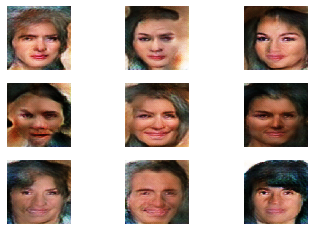

In [7]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()


# load model
model = load_model('models/generator_model_010.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 3)
